In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import html
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
# Load XML file
tree = ET.parse('whc.unesco.org.xml')
root = tree.getroot()
channel = root.find('channel')

In [3]:
# Extract title and description
data = []
for site in channel.findall('item'):
    title = site.find('title').text
    description = site.find('description').text
    data.append({'title': title, 'description': description})

# Convert to DataFrame
df = pd.DataFrame(data)

In [4]:
def clean_text(text):
        
    # Remove img tags
    text = re.sub(r'<img.*?>', '', text)
    
    # Remove p tags
    text = re.sub(r'<p>', '', text)
    text = re.sub(r'</p>', '', text)
    
    return text

In [5]:
df['clean_description'] = df['description'].apply(clean_text)

df['clean_description'] = df['clean_description'].apply(lambda x: html.unescape(html.unescape(x)))


In [6]:
# Clean and tokenize text
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    print("NLTK resources downloaded successfully")
except Exception as e:
    print(f"Failed to download NLTK resources: {e}")


NLTK resources downloaded successfully


In [7]:
stop_words = set(stopwords.words('english'))

# Add custom words to the stopwords set
custom_words = {
    "century", "site", "city", "period", "age", "year", "old", "early", "modern",
    "region", "area", "place", "property", "cultural", "historic", "world",
    "outstanding", "example", "building", "site", "built", "km", "ago"
}  # Add as many as you want
stop_words.update(custom_words)

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()

def prepare_text(text):
    tokens = word_tokenize(text.lower())
    alpha_tokens = [t for t in tokens if t.isalpha()]
    # print("Alphabetic Tokens:", alpha_tokens)
    interim_tokens = [t for t in alpha_tokens if t not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in interim_tokens]
    # print("Lemmatized Tokens:", lemmatized_tokens)
    filtered_tokens = [t for t in lemmatized_tokens if t not in stop_words]
    # print("Filtered Tokens:", filtered_tokens)
    return ' '.join(filtered_tokens)


In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

df['cleaner_description'] = df['clean_description'].apply(prepare_text)

df.drop(columns=['description'], inplace=True)

model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight BERT model
embeddings = model.encode(df["cleaner_description"])


c:\Pyth\G7-CR\Project_3\unesco\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
inertia = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

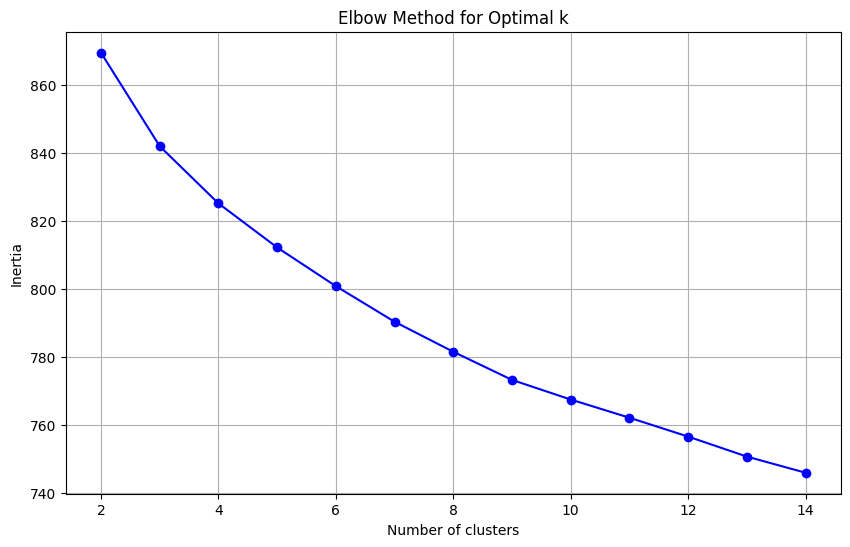

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [12]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(embeddings)

print(df[["clean_description", "cluster"]])
df.to_csv('clusters.csv')

                                      clean_description  cluster
0     The property encompasses the western part of t...        1
1     The property includes five aflaj irrigation sy...        2
2     The nine Sacri Monti (Sacred Mountains) of nor...        0
3     The monumental complex at Caserta, created by ...        0
4     Construction of this palatine chapel, with its...        0
...                                                 ...      ...
1218  This cultural landscape has been shaped for ce...        2
1219  The Zollverein industrial complex in Land Nord...        2
1220  Located on the steep cliffs in the border regi...        2
1221  Þingvellir (Thingvellir) is the National Park ...        2
1222  The ǂKhomani Cultural Landscape is located at ...        2

[1223 rows x 2 columns]


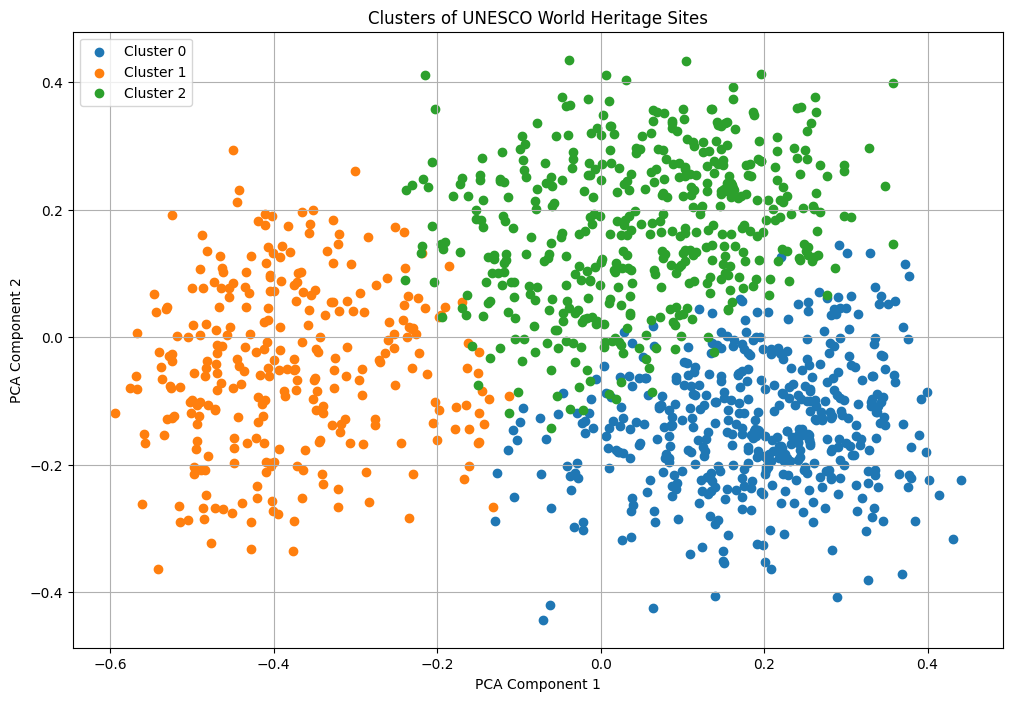

In [13]:
pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    cluster_points = coords[df['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of UNESCO World Heritage Sites')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

features = []

# Extract keywords per cluster
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df["cleaner_description"])

# Find top words per cluster
terms = vectorizer.get_feature_names_out()
cluster_keywords = {}

for cluster_num in range(num_clusters):
    cluster_texts = df[df["cluster"] == cluster_num]["cleaner_description"]
    cluster_tfidf = vectorizer.transform(cluster_texts)
    mean_tfidf = cluster_tfidf.mean(axis=0).A1
    top_words = [terms[i] for i in mean_tfidf.argsort()[-10:][::-1]]
    cluster_keywords[cluster_num] = top_words

# Print cluster names
for cluster, words in cluster_keywords.items():
    features.append(' '.join(words))
    print(f"Cluster {cluster}: {' '.join(words)}")


Cluster 0: town church architecture roman architectural style centre europe urban cathedral
Cluster 1: specie park forest island bird mountain plant national home lake
Cluster 2: temple capital archaeological remains landscape ancient culture palace tomb mountain


In [15]:
for i in range(num_clusters):
    print(f"\nCluster {i} Analysis:")
    print(f"Number of sites: {len(df[df['cluster'] == i])}")
    print(f"Top tearms: {features[i]}")
    print("Sample sites:")
    for _, row in df[df['cluster'] == i].head(5).iterrows():
        print(f"- {row['title']}")


Cluster 0 Analysis:
Number of sites: 468
Top tearms: town church architecture roman architectural style centre europe urban cathedral
Sample sites:
- Sacri Monti of Piedmont and Lombardy
- 18th-Century Royal Palace at Caserta with the Park, the Aqueduct of Vanvitelli, and the San Leucio Complex
- Aachen Cathedral
- Abbey and Altenmünster of Lorsch
- Abbey Church of Saint-Savin sur Gartempe

Cluster 1 Analysis:
Number of sites: 293
Top tearms: specie park forest island bird mountain plant national home lake
Sample sites:
- ‘Uruq Bani Ma'arid
- Aasivissuit – Nipisat. Inuit Hunting Ground between Ice and Sea
- Agricultural Landscape of Southern Öland
- Air and Ténéré Natural Reserves
- Aldabra Atoll

Cluster 2 Analysis:
Number of sites: 462
Top tearms: temple capital archaeological remains landscape ancient culture palace tomb mountain
Sample sites:
- Aflaj Irrigation Systems of Oman
- Aapravasi Ghat
- Agave Landscape and Ancient Industrial Facilities of Tequila
- Agra Fort
- Ajanta Cave

# UNESCO World Heritage Clustering – Summary

## Technologies Used

- **XML Parsing:** `xml.etree.ElementTree` for data extraction  
- **Data Handling:** `pandas`, `numpy`  
- **Natural Language Processing:** `nltk` for tokenization, lemmatization, and stopword removal  
- **Embeddings:** `SentenceTransformer` (MiniLM-L6-v2) for semantic vectorization  
- **Clustering:** `KMeans` from `scikit-learn`, with optimal `k` selected via the Elbow Method  
- **Dimensionality Reduction:** PCA for visualization  
- **Keyword Analysis:** `TfidfVectorizer` for cluster interpretation  
- **Visualization:** `matplotlib` for plotting inertia and clusters  

## Identified Cluster Themes

1. **Historic Towns & Architecture**  
   Sites featuring religious buildings, classical architecture, and culturally rich urban centers—mostly in Europe.

2. **Natural Landscapes & Biodiversity**  
   Includes parks, reserves, forests, and remote natural environments, emphasizing ecological and wildlife diversity.

3. **Ancient Civilizations & Archaeology**  
   Encompasses archaeological ruins, ancient cities, temples, and remnants of early human civilizations.
